In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria


In [17]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [18]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
conv_base.summary()
conv_base.trainable = False  # frozen to prevent weight updates

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',       # save path
    monitor='val_loss',             # monitor this
    save_best_only=True,            # only save if val_loss improves
    save_weights_only=False,        # saves entire model (not just weights)
    mode='min',                     # lower val_loss is better
    verbose=1
)


In [22]:
base_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"

img_size=224
batch_size=32

# Augment training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# No augmentation for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [46]:
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size),
    class_mode="binary",
    subset="training",
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size),
    class_mode="binary",
    subset="validation",
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [28]:
# Unfreeze last convolutional block (block5) of VGG16
conv_base.trainable = True
for layer in conv_base.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True   # Fine-tune block5 layers
    else:
        layer.trainable = False  # Keep others frozen

# Re-compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [29]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)


input_layer_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',         # What to watch
    patience=2,                 # Stop after 3 non-improving epochs
    restore_best_weights=True,  # Restore best weights seen on val set
    verbose = 1
)


In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [32]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',    # Metric to monitor
    factor=0.5,            # Reduce LR by this factor
    patience=2,            # Wait this many epochs before reducing
    verbose=1,             # Print update messages
    min_lr=1e-7            # Lower bound on LR
)


In [33]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stop, checkpoint, lr_scheduler])

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8303 - auc: 0.8960 - loss: 0.7965
Epoch 1: val_loss improved from inf to 0.48332, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 401s 564ms/step - accuracy: 0.8304 - auc: 0.8961 - loss: 0.7963 - val_accuracy: 0.9463 - val_auc: 0.9860 - val_loss: 0.4833 - learning_rate: 1.0000e-05
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9527 - auc: 0.9828 - loss: 0.4588
Epoch 2: val_loss improved from 0.48332 to 0.40461, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 380s 552ms/step - accuracy: 0.9527 - auc: 0.9828 - loss: 0.4587 - val_accuracy: 0.9510 - val_auc: 0.9891 - val_loss: 0.4046 - learning_rate: 1.0000e-05
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9586 - auc: 0.9879 - loss: 0.3818
Epoch 3: val_loss improved from 0.40461 to 0.37733, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 383s 556ms/step - accuracy: 0.9586 - auc: 0.9879 - l

In [36]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')


In [37]:
# Continue training from the saved model
history = best_model.fit(
    train_generator,
    epochs=15,                      # total number of epochs required
    initial_epoch=10,              # resume from epoch 10
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

Epoch 11/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9672 - auc: 0.9924 - loss: 0.2107
Epoch 11: val_loss improved from 0.24623 to 0.23665, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 399s 573ms/step - accuracy: 0.9672 - auc: 0.9924 - loss: 0.2107 - val_accuracy: 0.9583 - val_auc: 0.9882 - val_loss: 0.2367 - learning_rate: 1.0000e-05
Epoch 12/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9685 - auc: 0.9930 - loss: 0.1965
Epoch 12: val_loss did not improve from 0.23665
689/689 ━━━━━━━━━━━━━━━━━━━━ 377s 547ms/step - accuracy: 0.9685 - auc: 0.9930 - loss: 0.1965 - val_accuracy: 0.9441 - val_auc: 0.9878 - val_loss: 0.2526 - learning_rate: 1.0000e-05
Epoch 13/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9675 - auc: 0.9924 - loss: 0.1922
Epoch 13: val_loss improved from 0.23665 to 0.21673, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 387s 562ms/step - accuracy: 0.9675 - auc: 0.9924 - loss: 0.1922 - val_accuracy: 

In [41]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')


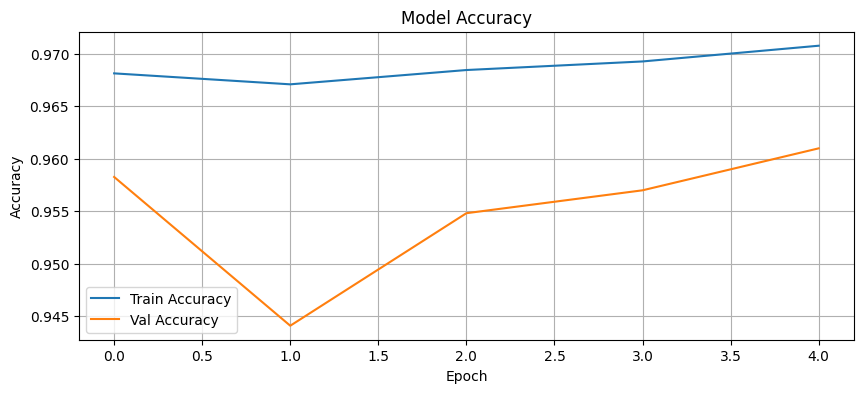

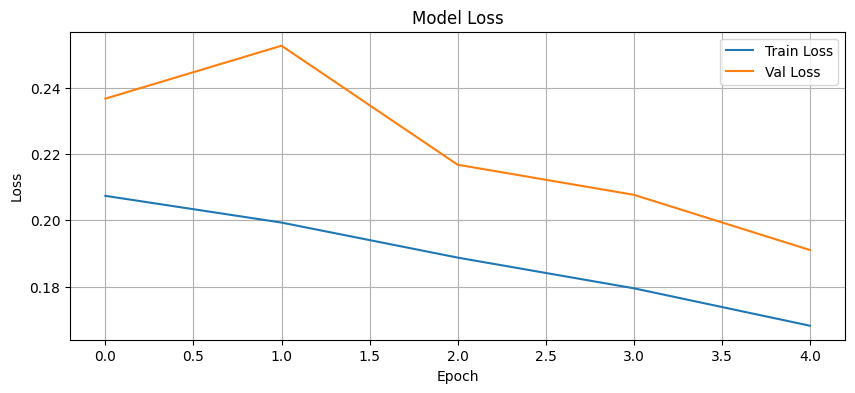

In [47]:
import matplotlib.pyplot as plt

# --- Accuracy Plot ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
from sklearn.metrics import classification_report, jaccard_score
import numpy as np

# Generate predicted probabilities for each image in validation set
y_pred_probs = best_model.predict(validation_generator)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# True labels from the validation generator
y_true = validation_generator.classes

# Classification Report provides:
# - Precision: % of predicted positives that are correct
# - Recall: % of actual positives correctly identified
# - F1-score: Harmonic mean of precision and recall (balanced metric)
print(classification_report(
    y_true, y_pred,
    target_names=validation_generator.class_indices.keys()
))

# Jaccard Index (IoU): Measures similarity between predicted and actual labels.
# Useful for segmentation or binary classification with imbalanced classes
print("Jaccard Index:", jaccard_score(y_true, y_pred))


173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2755
  Uninfected       0.95      0.97      0.96      2755

    accuracy                           0.96      5510
   macro avg       0.96      0.96      0.96      5510
weighted avg       0.96      0.96      0.96      5510

Jaccard Index: 0.9257596685082873


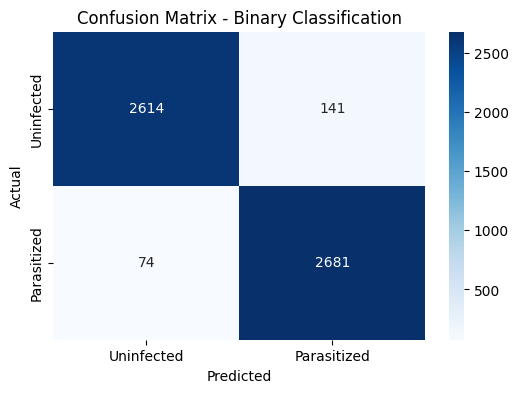

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix shows: TP, TN, FP, FN
# Helps understand which classes are being confused
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Uninfected", "Parasitized"],
    yticklabels=["Uninfected", "Parasitized"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Binary Classification")
plt.show()


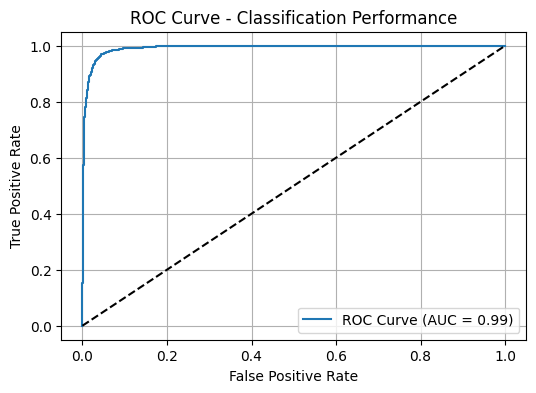

In [51]:
from sklearn.metrics import roc_curve, auc

# ROC curve plots: TPR vs FPR for all thresholds
# AUC (Area Under Curve) tells overall classifier quality
# Closer to 1 = better performance

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classification Performance")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
